**Overweiw

In the oil industry, one of the main tasks is the interpretation of well log data. After the well has been drilled, instruments that measure various physical characteristics of the rocks are dropped into it. After that, the obtained data are interpreted by petrophysicists, who isolate various lithologies, namely, clay and sandstone intervals. Isolation of lithology is a fairly routine, but very time-consuming task. Reinterpretation of data occurs quite often, both due to changes in the sandstone extraction model, and due to the emergence of new wells. Since the number of wells can amount to thousands, it is necessary to create a tool that could help a specialist in this task.

In [1]:
import pandas as pd
import numpy as np
import random as rd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV, validation_curve, learning_curve
import time
import math

In [2]:
ALL_train_data = pd.read_csv('Well_logs_interp_test_train.csv')

In [3]:
train_data=ALL_train_data.sample(frac=0.1,random_state=200)

Based on the sedimentological description of one of the outcrops of geological outcrops, located in the Tomsk region (Shestakovsky polygon), a 3D geological model was constructed.

The model is a three-dimensional grid of cells. Each cell is defined as sandstone, or as clay, and each of them has a record of geophysical studies.

The Well column shows which well the measurements belong to. The name of the well reflects its coordinates on the field.

Each well is represented by 4 logging curves:

**DEPT (depth of discrete recording, in general, it does not interest us and cannot act as a sign, since it depends on various tectonic movements that occurred after sedimentation, and not on the process of formation of geological bodies)

**SP (log of natural polarization, the latter occurs when the fluid is filtered through the rock, a decrease in values indicates the presence of a permeable interval, the unit of measurement is millivolts)

**GR (gamma logging, measures the natural radioactivity of rocks, various minerals have different content of radioactive materials, as a rule, the higher - the more clay component and less sandy, measured in units of API)

**DT (acoustic logging, measures the speed of the acoustic wave passing through the rock, as a rule, with lower values may indicate both the high porosity characteristic of sandstone and the amount of clay, measured in microseconds / meter)

**Density (density logging, based on Compton scattering, reflects rock density, measured in grams / cm ^ 3)

As an interpretation curve, the column is Litho, which with a value of 1 speaks of sandstone, and with a value of 0, it refers to clay.

**Primary data analysis

In [25]:
# Let's see what data types are represented in the uploaded file and whether there are any gaps in it.
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15179 entries, 130176 to 48933
Data columns (total 7 columns):
DEPT     15179 non-null float64
SP       15179 non-null float64
GR       15179 non-null float64
DT       15179 non-null float64
Dens     15179 non-null float64
Litho    15179 non-null float64
Well     15179 non-null object
dtypes: float64(6), object(1)
memory usage: 1.6+ MB


In [ ]:
# It can be concluded that there are no gaps, and all the described curves of geophysical studies are presented in full.

In [24]:
# We look at the description of the data, we estimate the main statistical characteristics
# Also see 5 and 95 percentile for estimating emissions
print(train_data.quantile(0.05))
print(train_data.quantile(0.95))
train_data.describe()

DEPT     2497.400000
SP       -122.799255
GR         60.174496
DT        292.787216
Dens        2.303260
Litho       0.000000
Name: 0.05, dtype: float64
DEPT     2527.400000
SP        -40.757374
GR        115.377512
DT        327.807358
Dens        2.370420
Litho       1.000000
Name: 0.95, dtype: float64


,DEPT,SP,GR,DT,Dens,Litho
count,15179.000000,15179.000000,15179.000000,15179.000000,15179.000000,15179.000000
mean,2514.051097,-77.298519,90.945001,307.066875,2.342436,0.322024
std,9.205079,27.515328,19.737567,11.643088,0.022095,0.467267
min,2486.300000,-125.629440,57.799000,283.743622,2.296691,0.000000
25%,2507.800000,-101.729607,72.013474,297.874008,2.324470,0.000000
50%,2514.800000,-72.878921,93.364952,302.934937,2.349560,0.000000
75%,2521.000000,-52.375853,110.952461,316.564819,2.359802,1.000000
max,2543.400000,-39.054886,116.948357,330.143646,2.389459,1.000000


You can see that the values are on completely different scales, which is natural, since different physical characteristics are measured. According to the Litho column, it can be noted that the sandstone takes up only 33 percent of the data, which makes the problem somewhat unbalanced. Since the 5th and 95th percentiles have values close to the minimum and maximum, you should check the data for emissions.

In [6]:
# Additionally, we estimate the amount of outliers, go beyond two standard deviations for each of the curve
for column in ['SP', 'GR', 'DT', 'Dens']:
    mean = train_data[column].mean()
    std = train_data[column].std()
    print('Number of outlies for well log %s is %d'%(column,
                                                     (train_data.loc[train_data[column] >=
                                                                     mean + 2*std,column].shape[0] + 
                                                      train_data.loc[train_data[column] <=
                                                                     mean - 2*std,column].shape[0])))

Number of outlies for well log SP is 0
Number of outlies for well log GR is 0
Number of outlies for well log DT is 1
Number of outlies for well log Dens is 31


You can see that the density log contains a significant amount of outlier in terms of standard deviations that need to be processed.

In [7]:
# View statistics by data only inside sandstone
train_data[train_data.Litho == 1].describe()

,DEPT,SP,GR,DT,Dens,Litho
count,4888.000000,4888.000000,4888.000000,4888.000000,4888.000000,4888.0
mean,2516.843208,-106.765084,69.247270,321.021907,2.316286,1.0
std,8.078680,16.127664,10.204019,6.766792,0.013024,0.0
min,2487.300000,-125.629440,57.799000,300.197052,2.296691,1.0
25%,2512.200000,-120.636316,60.727578,316.011696,2.305137,1.0
50%,2517.600000,-111.662884,65.062473,322.914368,2.313217,1.0
75%,2522.300000,-95.796068,76.140747,327.114555,2.325962,1.0
max,2543.400000,-53.976311,100.879814,330.143646,2.356822,1.0


It can be noted that the sandstone intervals of the SP and GR curves are of lower values, which is quite natural, since the sandstone contains few clay radioactive minerals, and the ability of the interval to filter creates a potential difference. Somewhat lower density values indicate the presence of pore space and are a sign of sandstone. Elevated values of the interval run time of the wave indicate a lower velocity, which also implies the last conclusion about the presence of pore space, since the speed of wave propagation in low-density materials is lower

In [8]:
# Let's see the statistics by data only inside the clay
train_data[train_data.Litho == 0].describe()

,DEPT,SP,GR,DT,Dens,Litho
count,10291.000000,10291.000000,10291.000000,10291.000000,10291.000000,10291.0
mean,2512.724905,-63.302546,101.250949,300.438540,2.354857,0.0
std,9.408805,19.617390,13.975580,6.462441,0.012666,0.0
min,2486.300000,-123.448090,62.527611,283.743622,2.307167,0.0
25%,2506.200000,-75.429688,92.127937,297.109665,2.348694,0.0
50%,2513.000000,-58.809128,104.886940,298.585815,2.357512,0.0
75%,2520.100000,-46.918980,114.104370,303.325516,2.362158,0.0
max,2542.400000,-39.054886,116.948357,325.850250,2.389459,0.0


In clay intervals, we see a reverse situation, the SP and GR curves have elevated values, the density logging data also slightly increased, and the acoustic curve values also decreased.

In [9]:
# Estimate the parameter correlation
corr_mat = train_data.corr()
corr_mat

,DEPT,SP,GR,DT,Dens,Litho
DEPT,1.000000,-0.315135,-0.292587,0.252400,-0.248595,0.209053
SP,-0.315135,1.000000,0.967714,-0.845411,0.832823,-0.738084
GR,-0.292587,0.967714,1.000000,-0.827517,0.811950,-0.757656
DT,0.252400,-0.845411,-0.827517,1.000000,-0.981568,0.826064
Dens,-0.248595,0.832823,0.811950,-0.981568,1.000000,-0.815690
Litho,0.209053,-0.738084,-0.757656,0.826064,-0.815690,1.000000



As previously assumed, there is no correlation between depth and physical characteristics, due to the fact that not a very large interval of the reservoir is considered (at depths measured by kilometers, some connection must be traced in connection with compaction of rocks and high pressures). You can also note the high correlation of logging, which is natural, since many physical characteristics are closely related to each other.

**Visual data analysis

In this block, a visual analysis of the data will be carried out in order to get some additional information about the distribution of parameters, the existing dependencies in them, and to estimate emissions.

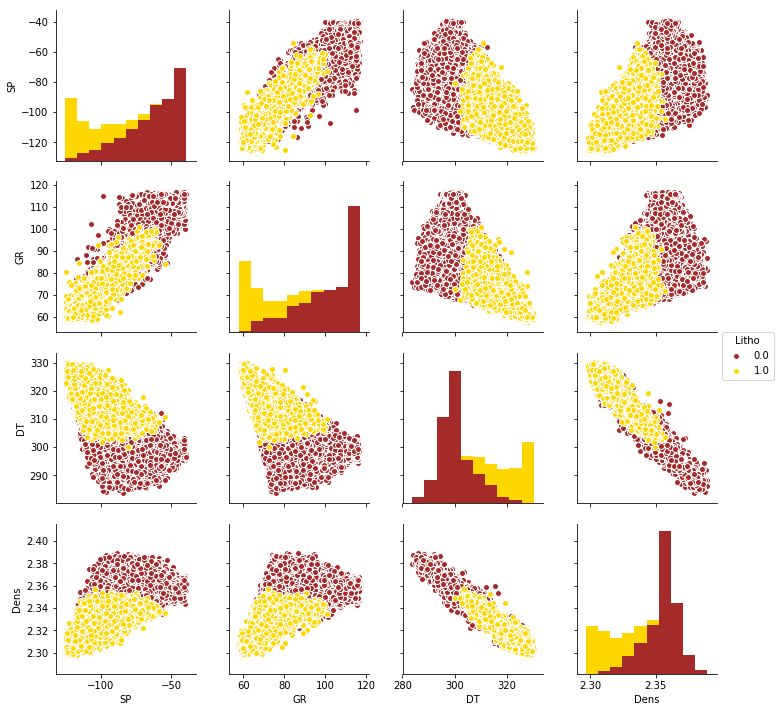

In [10]:
# Visual assessment of available information with using pairplot
sns.pairplot(train_data, vars = ['SP', 'GR', 'DT', 'Dens'], hue = 'Litho', palette = ['brown', 'gold'])

According to the results of visual assessment, it can be noted that the classes are fairly well linearly separable in the field of two values, although there is a significant proportion of overlap, which does not allow for a linear value to be easily obtained by linear models. It is also important to note the presence of outliers that were not identified during the initial analysis and which should be further processed. For example, flying off points on cross-rafts of GR and SP curves.

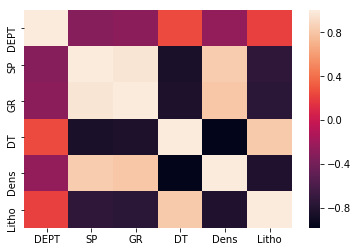

In [11]:
# Construct a heatmap using the previously created correlation matrix for a more visual assessment 
# of the relationships between the curves

sns.heatmap(corr_mat)

On the basis of the temperature map, everything is also confirmed by the assumption that there are no links between the instrument readings (litho) and the depth, so this parameter can not be used, since it can introduce additional noise.

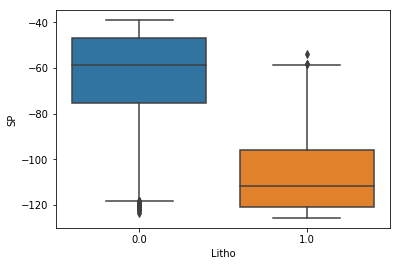

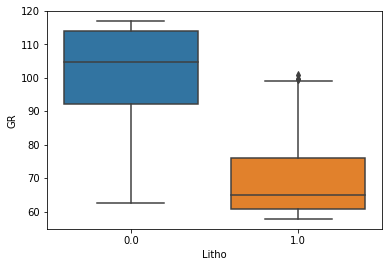

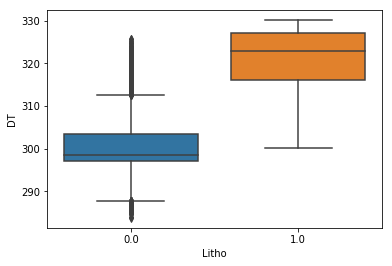

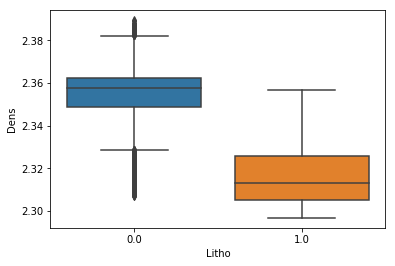

In [12]:
# Build box rafts using four geophysical curves to estimate the distribution of values within classes
for column in ['SP', 'GR', 'DT', 'Dens']:
    plt.figure()
    sns.boxplot(data = train_data, x = 'Litho', y = column)
    plt.show()

Again, you can see that most of the data is fairly linearly separable, but such a separation will not provide the necessary level of accuracy due to the existing overlaps.

It is also worth noting the presence of a significant amount of outlier of acoustic and density logging in clay intervals.

**Insights, dependencies

According to the results of the analysis, it can be noted that the curves correlate quite well. There is also a link between classes and curve values. So, the target class of sandstone (1) is characterized by lower values of the SP and GR curves, since the intervals during the filtration of the fluid create a potential difference, and the presence of a small amount of clay does not allow the gamma logging curve to increase. Lower density values suggest the presence of pore space characteristic of sandstones. Elevated values of the interval time of wave travel are associated with a decrease in speed, which in turn depends on the density of the rock. Recent statements also suggest that in the future it is worth trying the use of an additional feature - acoustic impedance, which is the product of rock density and velocity in it.

According to the results of the analysis, both primary and visual, it was found that the classes are fairly well linearly divided in the field of two logging curves. At the same time, the separation is far from ideal and needs to be improved through the construction of new features.

A significant number of departures were identified, especially on the density log. In the future, such points need to be processed (the replacement of values with two standard deviations by the value of two standard deviations).

An important conclusion was the conclusion about the possibility of extracting additional information from the coordinates of the well, which were not previously considered as a sign that can be used. In the future, it is worth trying it out as an additional feature.


**Metric selection

The Accuracy metric does not fit because there is an imbalance of classes, and, for example, if the algorithm predicts all values as clay, then we immediately get 70% accuracy, which is not true

First of all, attention will be focused precisely on AUC, since it is ideally suited for the problem of binary classification in which there is a problem of class imbalance.

**Model selection

The main requirements for the model are the ability to work with multi-scale data, resistance to emissions and imbalances in the classes.

Since the same curves of logging studies have the same scale in all wells, there is no need to use models that could be divided by the classes for values that are out of these scales. Thus, you can immediately exclude linear models. A number of models require that all data be on the same scale, which is not the case for this task. Data can be normalized, but this can lead to other problems. Therefore, for the time being, it is worthwhile to abandon similar models, for example, K closest neighbors.

For this task, models that work on building ensembles of trees are ideal. Ensembles are resistant to emissions and they do not care about the scale of the data. A huge advantage is their ability to "push apart" classes, which, as was shown earlier, are quite strongly overlapped. An important advantage is more stable operation with unbalanced sampling, thanks to bagging and boosting.

In this paper, the scikit-learn classifier GradientBoostinClassifier of the library was chosen as one of the best representatives in its class.


In [15]:
# We process outliers, equating all values behind the 5th or 95th percentile to the corresponding values

train_no_outliers = train_data.copy()
for column in ['SP', 'GR', 'DT', 'Dens']:
    quant_95 = train_no_outliers[column].quantile(0.95)
    quant_5 = train_no_outliers[column].quantile(0.05)
    train_no_outliers.loc[train_no_outliers[column] > quant_95, column] = quant_95
    train_no_outliers.loc[train_no_outliers[column] < quant_5, column] = quant_5

In [27]:
# We split the data into a training and hold-out sample by wells
train_test = 0.7
rd.seed(17)
train_wells = rd.sample(train_data.Well.unique().tolist(), round(train_test*len(train_data.Well.unique())))
train_set = train_no_outliers.loc[train_no_outliers.Well.isin(train_wells)]
test_set = train_no_outliers.loc[~train_no_outliers.Well.isin(train_wells)]

In [18]:
# We divide the resulting samples into the matrix of features and the response vector
Feature_train = train_set.drop(['Well', 'DEPT', 'Litho'], axis = 1)
Target_train = train_set['Litho']

Feature_test = test_set.drop(['Well', 'DEPT', 'Litho'], axis = 1)
Target_test = test_set['Litho']

In [26]:
# Let's build a baseline model of logistic regression from which metrics we will build on
baseline_clf = RidgeClassifier()
baseline_clf.fit(Feature_train, Target_train)
baseline_prediction = baseline_clf.predict(Feature_test)
roc_auc_base = roc_auc_score(Target_test, baseline_prediction)
f1_base = f1_score(Target_test, baseline_prediction)
print('ROC-AUC metrics of the baseline model is %.4f'%roc_auc_base)

ROC-AUC metrics of thr baseline model is 0.8934


As you can see, the result is already quite good, but it was quite obvious that the linear separation should behave well.

In [20]:
# Create an object for cross-validation selection
stratified_cv = StratifiedKFold(n_splits=3, random_state=17)

In [21]:
# Create the very model 
clf = GradientBoostingClassifier(random_state=17,
                                 learning_rate = 0.01,
                                 subsample = 0.5,
                                max_depth = 4,
                                max_features = 'auto')

# Determine the dictionary of parameters by which the selection of signs will occur

grid_params = {'n_estimators':list(range(100, 1001, 100))}

# Create a classifier to search for the best hyperparameters
# Since the range of hyperparameters is very wide, 5 folds cross-validation
# Use RandomizedSearchCV instead of the standard GridSearchCV, which passes through all variations of parameters

grid_clf = GridSearchCV(clf, 
                              param_grid=grid_params,
                              cv = stratified_cv,
                              scoring = 'roc_auc',
                              n_jobs = -1)

start_time = time.time()

# Training of model
grid_clf.fit(Feature_train, Target_train)

end_time = time.time()

print('Model trained in %d seconds.'%(end_time-start_time))

Модель обучилась за 63 секунд.


In [22]:
# Determine the best model parameters

print('Selected number of trees:\n%s'%grid_clf.best_params_['n_estimators'])

# Determine the accuracy of the model for cross-validation
print('For cross-validation, the best results for ROC-AUC were %.4f'%grid_clf.best_score_)

# Determine the accuracy of the model on the test sample to compare it with the baseline solution
prediction_clf = grid_clf.predict(Feature_test)
roc_auc_clf = roc_auc_score(Target_test, prediction_clf)
f1_clf = f1_score(Target_test, prediction_clf)
print('ROC-AUC metric of the obtained gradient boosting model on the test part is equal to %.4f'%roc_auc_clf)
print('The difference between the tuned gradient boosting model and the baseline on the ROC-AUC metric is %.4f'%(
    roc_auc_clf-roc_auc_base))

Выбранное количество деревьев:
900
На кросс валидации лучший результаты по ROC-AUC составил 0.9835
ROC-AUC метрика полученной модели градиентного бустинга на тестовой части равна 0.9094
F1 метрика полученной модели градиентного бустинга на тестовой части равна 0.8758
Разница между настроенной моделью градиентного бустинга и baseline по ROC-AUC метрике равна 0.0161
Разница между настроенной моделью градиентного бустинга и baseline по F1 метрике равна 0.0204
